# Visualise Trained Pytorch model and results

## Import libraries and plot training

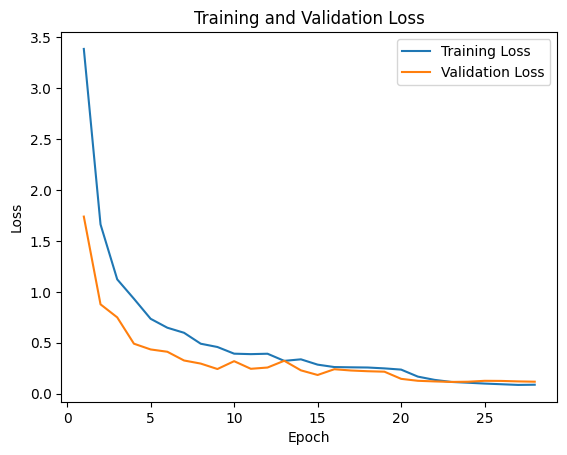

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import pandas as pd
from anytree import Node
from anytree.importer import JsonImporter
import torch.nn as nn
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
from models.hierarchical_cnn import HierarchicalCNN
from utils.custom_dataset import CustomDataset

# Read the training log file
training_log = pd.read_csv('logs/model_alpha_05.csv')

# Plot the training and validation loss
plt.plot(training_log['Epoch'], training_log['Training Loss'], label='Training Loss')
plt.plot(training_log['Epoch'], training_log['Validation Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Extract test data

In [2]:
# %%
df = pd.read_parquet('/mnt/RAID/projects/FjordVision/data/segmented-objects-dataset.parquet')

# Assuming df is your DataFrame with all data
train_val_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

# Load The Model and Ontology

In [3]:
importer = JsonImporter()
root = importer.read(open('data/ontology.json', 'r'))

classes_file = '/mnt/RAID/datasets/label-studio/fjord/classes.txt'

species_names = []
with open(classes_file, 'r') as file:
    species_names = [line.strip() for line in file]

genus_names = [node.name for node in root.descendants if node.rank == 'genus']
class_names = [node.name for node in root.descendants if node.rank == 'class']
binary_names = [node.name for node in root.descendants if node.rank == 'binary']

def get_hierarchical_labels(species_index, root):
    if species_index == -1:
        return -1, -1, -1  # Handle cases where species_index is invalid

    species_name = species_names[species_index]
    node = next((n for n in root.descendants if n.name == species_name), None)

    if node is None:
        return -1, -1, -1  # Species not found in the tree

    # Traverse up the tree to find genus, class, and binary ranks
    genus_index, class_index, binary_index = -1, -1, -1
    current_node = node

    while current_node.parent is not None:
        current_node = current_node.parent
        if current_node.rank == 'genus':
            genus_index = genus_names.index(current_node.name)
        elif current_node.rank == 'class':
            class_index = class_names.index(current_node.name)
        elif current_node.rank == 'binary':
            binary_index = binary_names.index(current_node.name)

    return genus_index, class_index, binary_index

class_name_lists = [binary_names, class_names, genus_names, species_names]
                    
# Create a defaultdict to store the counts for each rank
rank_counts = defaultdict(int)

# Iterate over the nodes of the tree
for node in root.descendants:
    rank = node.rank
    rank_counts[rank] += 1

# Example instantiation of the model
num_classes_hierarchy = list(rank_counts.values())  # Example: [num_species, num_genus, num_class, num_binary]
num_additional_features = 3  # Assuming 3 additional features: conf, iou, pred_species

model = HierarchicalCNN(num_classes_hierarchy, num_additional_features)
model.load_state_dict(torch.load('/mnt/RAID/projects/FjordVision/models/weights/best_model_alpha_05.pth'))

RuntimeError: Error(s) in loading state_dict for HierarchicalCNN:
	size mismatch for branches.0.fc_layers.0.weight: copying a param with shape torch.Size([1024, 122883]) from checkpoint, the shape in current model is torch.Size([1024, 3753]).
	size mismatch for branches.1.fc_layers.0.weight: copying a param with shape torch.Size([1024, 61443]) from checkpoint, the shape in current model is torch.Size([1024, 3753]).
	size mismatch for branches.2.fc_layers.0.weight: copying a param with shape torch.Size([1024, 25603]) from checkpoint, the shape in current model is torch.Size([1024, 3753]).
	size mismatch for branches.3.fc_layers.0.weight: copying a param with shape torch.Size([1024, 9603]) from checkpoint, the shape in current model is torch.Size([1024, 3753]).

# Load Dataloader

In [ ]:
test_dataset = CustomDataset(test_df, species_names, genus_names, class_names, binary_names, root)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Extract Predictions on test data

In [ ]:
(test_df['predicted_species'] == test_df['species']).sum() / len(test_df)

In [ ]:
from sklearn.metrics import f1_score
import numpy as np

# Initialize lists to store true labels and predictions for each level
true_labels = {level: [] for level in ['binary', 'class', 'genus', 'species']}
predictions = {level: [] for level in ['binary', 'class', 'genus', 'species']}

model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

model.eval()
with torch.no_grad():
    for images, conf, iou, pred_species, species_index, genus_index, class_index, binary_index in test_loader:
        images, conf, iou, pred_species = images.to(device), conf.to(device), iou.to(device), pred_species.to(device)
        
        outputs = model(images, conf, iou, pred_species)
        
        # Convert model outputs to predictions
        for i, output in enumerate(outputs):  # For each hierarchical level
            _, predicted = torch.max(output, 1)
            level = ['binary', 'class', 'genus', 'species'][i]
            predictions[level].extend(predicted.cpu().numpy())
        
        # Store true labels
        true_labels['binary'].extend(binary_index.cpu().numpy())
        true_labels['class'].extend(class_index.cpu().numpy())
        true_labels['genus'].extend(genus_index.cpu().numpy())
        true_labels['species'].extend(species_index.cpu().numpy())

In [ ]:
f1_scores = {}
for level in ['binary', 'class', 'genus', 'species']:
    f1_scores[level] = f1_score(true_labels[level], predictions[level], average='macro')
    print(f"F1 Score for {level}: {f1_scores[level]:.4f}")

# Visualise CNN

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as F
from torchvision.utils import make_grid
import torch

def transform_activations(activations):
    """
    Transforms activations from (C x B x H x W) to (B x C x H x W).
    Specifically handles the case where C should be treated as B for visualization.
    """
    # Assuming activations is of shape (1, 30, 64, 64) and we want (30, 1, 64, 64)
    B, C, H, W = activations.shape[1], 1, activations.shape[2], activations.shape[3]
    return activations.permute(1, 0, 2, 3).view(B, C, H, W)

def resample_activations_to_grid(activations, nrow=4):
    """
    Ensures there are nrow*nrow activation maps by either repeating or subsetting.
    Adjusted for a 4x4 grid.
    """
    total_needed = nrow * nrow  # Adjusted for a 4x4 grid
    current_count = activations.shape[0]

    if current_count < total_needed:
        repeats = total_needed // current_count + 1
        activations = activations.repeat(repeats, 1, 1, 1)[:total_needed]
    elif current_count > total_needed:
        indices = torch.linspace(0, current_count - 1, total_needed).long()
        activations = activations[indices]

    return activations

def visualize_hierarchical_predictions_and_activations(image, activations, true_labels, predictions, class_name_lists):
    """
    Visualizes original image and activations for binary, class, genus, and species levels,
    incorporating resampling to ensure 4x4 grids and applying a colormap directly to tensor data.
    """
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))  # Adjusted subplot size for better visualization
    levels = ['original', 'binary', 'class', 'genus', 'species']

    # Original image visualization
    img_np = np.transpose(image.cpu().numpy(), (1, 2, 0))
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
    axs[0].imshow(img_np)
    axs[0].axis('off')

    # Visualize activations for each level
    for i, level in enumerate(levels):
        if i == 0: continue
        current_activation = activations[i-1]
        current_activation = transform_activations(current_activation)
        current_activation = resample_activations_to_grid(current_activation, nrow=4)  # Ensure 4x4 grid
        activation_grid = make_grid(current_activation, nrow=4, normalize=True, padding=2)

        # Directly convert the grid tensor to a NumPy array and apply cmap
        grid_np = np.transpose(activation_grid.cpu().numpy(), (1, 2, 0))
        axs[i].imshow(grid_np[:, :, 0], cmap='viridis')  # Ensures viridis is applied for single-channel images
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

selected_species_idx = 10

model = HierarchicalCNN(num_classes_hierarchy, num_additional_features)
model.load_state_dict(torch.load('/mnt/RAID/projects/FjordVision/models/weights/best_model_alpha_05.pth'))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.register_hooks()

# Get one random sample from the DataLoader
for images, conf, iou, pred_species, species_index, genus_index, class_index, binary_index in test_loader:
    # Assuming you have a way to select a sample of a specific class; here we simply choose the first one
    if species_index[0].item() == selected_species_idx:
        selected_image = images[0].unsqueeze(0).to(device)
        selected_conf = conf[0].unsqueeze(0).to(device)
        selected_iou = iou[0].unsqueeze(0).to(device)
        selected_pred_species = pred_species[0].unsqueeze(0).to(device)
        _ = model(selected_image, selected_conf, selected_iou, selected_pred_species)
        break  # We only need one batch
    else:
        continue

# Assuming `model.activations` contains the relevant activations for visualization
# `true_labels` and `predictions` should be populated accordingly
visualize_hierarchical_predictions_and_activations(
    selected_image.squeeze(0), 
    model.activations, 
    {'binary': binary_index[0].item(), 'class': class_index[0].item(), 'genus': genus_index[0].item(), 'species': species_index[0].item()}, 
    predictions, 
    class_name_lists
)

# Find Segmentation of Selected Class

In [ ]:
selected_species_idx = 10

species_df = df[df['species'] == species_names[selected_species_idx]]
species_df.sample(1).masked_image

In [ ]:
species_names

# Visualise most likely classes

In [ ]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Assuming model is your HierarchicalCNN instance
# Ensure your model is on the desired device, e.g., GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to the specified device
model.eval()  # Set model to evaluation mode

# Initialize a random noise image with gradients enabled
image = torch.randn(1, 3, 128, 128, device=device, requires_grad=True)

# Choose the target class and the branch index
target_class = 10  # Example target class
branch_index = 3  # Example branch index corresponding to one of the branches in your model

# Define optimizer for the image
optimizer = optim.Adam([image], lr=0.01)

for iteration in range(300):  # Number of iterations to optimize the image
    optimizer.zero_grad()
    
    # Forward pass through the model
    # Assuming dummy additional features are acceptable and do not affect the forward pass negatively
    outputs = model(image, torch.tensor([0.0], device=device), torch.tensor([0.0], device=device), torch.tensor([0.0], device=device))
    target_output = outputs[branch_index]  # Select the output from the target branch
    
    # Calculate loss as negative score for the target class
    loss = -target_output[0, target_class]
    loss.backward()  # Compute gradients for the image
    
    # Update the image via gradient ascent
    optimizer.step()

# Clip the image values to make it displayable
image = image.detach().cpu().squeeze().numpy()  # Remove batch dimension and transfer to CPU
image = np.transpose(image, (1, 2, 0))  # Change from (C, H, W) to (H, W, C) for plotting
image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1] for valid image display

# Display the optimized image
plt.imshow(image)
plt.title("Optimized Image")
plt.axis('off')
plt.show()

In [ ]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image, ImageFilter
import torch.nn.functional as F

# Assuming model is your HierarchicalCNN instance already defined
# Ensure your model is on the desired device, e.g., GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Choose the target class and the branch index
target_class = 0  # Update this based on your target class
branch_index = 3  # Update this based on your branch index

# Initialize a starting low-resolution image with gradients enabled
initial_resolution = 56
image = torch.randn(1, 3, initial_resolution, initial_resolution, device=device, requires_grad=True)

# Function to apply Gaussian blur
def apply_gaussian_blur(image, radius=1):
    pil_img = transforms.ToPILImage()(image.cpu().squeeze(0))
    blurred_img = pil_img.filter(ImageFilter.GaussianBlur(radius))
    return transforms.ToTensor()(blurred_img).unsqueeze(0).to(device)

# Upscale and blur function
def upscale_and_blur(image, upscale_factor=1.2, blur_radius=1):
    with torch.no_grad():
        new_size = [int(dim * upscale_factor) for dim in image.shape[2:]]
        upsampled_image = F.interpolate(image, size=new_size, mode='bilinear', align_corners=False)
        blurred_image = apply_gaussian_blur(upsampled_image, radius=blur_radius)
    return blurred_image.requires_grad_(True)

# Define optimizer for the image
optimizer = optim.Adam([image], lr=0.05)

# Optimization and upscaling loop
scaling_steps = 5  # How many times to upscale and blur
for scale_step in range(scaling_steps):
    for iteration in range(200):  # Optimizations per scale
        optimizer.zero_grad()

        # Dummy additional features, assuming they're required for your model's forward method
        conf = torch.tensor([0.0], device=device)
        iou = torch.tensor([0.0], device=device)
        pred_species = torch.tensor([0.0], device=device)
        
        outputs = model(image, conf, iou, pred_species)
        target_output = outputs[branch_index]

        # Calculate loss as the negative score for the target class
        loss = -target_output[0, target_class]
        loss.backward()

        # Update the image via gradient ascent
        optimizer.step()

    # Upscale and blur, if not on the last scaling step
    if scale_step < scaling_steps - 1:
        image = upscale_and_blur(image, upscale_factor=1.2, blur_radius=1)
        optimizer = optim.Adam([image], lr=0.05)  # Re-initialize the optimizer for the new image tensor

# Convert the optimized image to a displayable format
image_np = image.detach().cpu().squeeze().numpy()
image_np = np.transpose(image_np, (1, 2, 0))  # CHW to HWC
image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())  # Normalize to [0, 1]

# Display the optimized image
plt.imshow(image_np)
plt.title("Optimized Image")
plt.axis('off')
plt.show()